# Malta Independant

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

from torch.utils.data import DataLoader, TensorDataset

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import os

In [3]:
# Load datasets
pwd = os.getcwd()

mi_data = pd.read_csv(pwd + '\merged_data.csv')
mbw_data = pd.read_csv(fr'C:\Users\ivane\Desktop\Dissertation\data\merged_data.csv')

# Convert date columns to datetime
mi_data['date'] = pd.to_datetime(mi_data['date'])
mbw_data['Date'] = pd.to_datetime(mbw_data['Date'])

# Sort by date
mi_data = mi_data.sort_values('date')
mbw_data = mbw_data.sort_values('Date')

# Reset index
mi_data = mi_data.reset_index(drop=True)
mbw_data = mbw_data.reset_index(drop=True)

print("Malta Independent Data Shape:", mi_data.shape)
print("Malta Business Weekly Data Shape:", mbw_data.shape)

Malta Independent Data Shape: (1001, 6)
Malta Business Weekly Data Shape: (430, 6)


## LSTM (without sentiment variables)

In [89]:
pwd = os.getcwd()

df = pd.read_csv(pwd + '\merged_data.csv')
df.head()

,date,Open,Close,Change,majority_sentiment,average_sentiment
0,2025-02-28,3913.54,3915.439,0.048601,2,0.890644
1,2025-02-27,3908.73,3913.537,0.122904,2,0.954200
2,2025-02-26,3910.01,3908.733,-0.032736,0,0.812788
3,2025-02-25,3920.37,3910.013,-0.264057,2,0.835742
4,2025-02-24,3883.52,3920.365,0.948727,2,0.809047


In [90]:
df.columns

Index(['date', 'Open', 'Close', 'Change', 'majority_sentiment',
       'average_sentiment'],
      dtype='object')

In [ ]:

df['date'] = pd.to_datetime(df['date'])

features = ['Open', 'Change'] 
target = 'Close'

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features + [target]])

In [ ]:

def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length, -1] 
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


seq_length = 10 
X, y = create_sequences(scaled_data, seq_length)

train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]



model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=1)) 

model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1) 


loss = model.evaluate(X_test, y_test)


Epoch 1/50


25/25 [==============================] - 4s 7ms/step - loss: 0.0188
Epoch 2/50
25/25 [==============================] - 0s 7ms/step - loss: 0.0029
Epoch 3/50
25/25 [==============================] - 0s 8ms/step - loss: 0.0022
Epoch 4/50
25/25 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 5/50
25/25 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 6/50
25/25 [==============================] - 0s 7ms/step - loss: 0.0017
Epoch 7/50
25/25 [==============================] - 0s 7ms/step - loss: 0.0015
Epoch 8/50
25/25 [==============================] - 0s 7ms/step - loss: 0.0014
Epoch 9/50
25/25 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 10/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 11/50
25/25 [==============================] - 0s 7ms/step - loss: 9.8959e-04
Epoch 12/50
25/25 [==============================] - 0s 7ms/step - loss: 8.5631e-04
Epoch 13/50
25/25 [==============================] -

7/7 [==============================] - 1s 3ms/step
Test Loss (MSE): 0.0005052234046161175
Mean Absolute Error (MAE): 31.609900023181
R-squared (R2): 0.8499226893849482


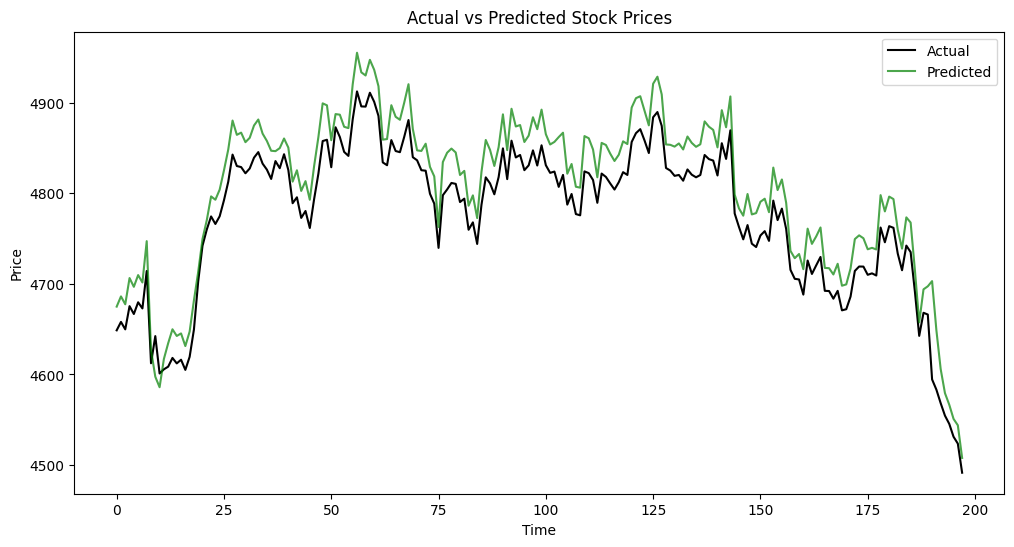

In [ ]:
import matplotlib.pyplot as plt


y_pred = model.predict(X_test)

y_test_actual = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_actual = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_pred.reshape(-1, 1)), axis=1))[:, -1]

mae = mean_absolute_error(y_test_actual, y_pred_actual)

r2 = r2_score(y_test_actual, y_pred_actual)

print(f"Test Loss (MSE): {loss}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual', color='black')
plt.plot(y_pred_actual, label='Predicted', color='green', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

## LSTM (with sentiment varaibles)

Epoch 1/50
25/25 [==============================] - 3s 7ms/step - loss: 0.0171
Epoch 2/50
25/25 [==============================] - 0s 7ms/step - loss: 0.0036
Epoch 3/50
25/25 [==============================] - 0s 7ms/step - loss: 0.0025
Epoch 4/50
25/25 [==============================] - 0s 7ms/step - loss: 0.0023
Epoch 5/50
25/25 [==============================] - 0s 7ms/step - loss: 0.0021
Epoch 6/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 7/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 8/50
25/25 [==============================] - 0s 7ms/step - loss: 0.0017
Epoch 9/50
25/25 [==============================] - 0s 7ms/step - loss: 0.0017
Epoch 10/50
25/25 [==============================] - 0s 8ms/step - loss: 0.0013
Epoch 11/50
25/25 [==============================] - 0s 7ms/step - loss: 0.0013
Epoch 12/50
25/25 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 13/50
25/25 [==============================

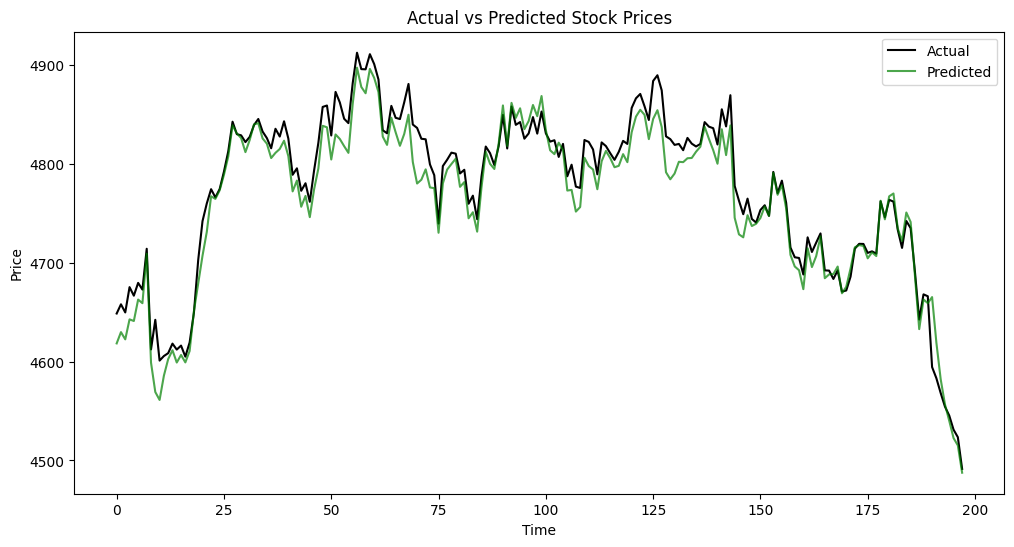

In [ ]:
import matplotlib.pyplot as plt

features = ['Open', 'Change', 'majority_sentiment', 'average_sentiment'] # Add more relevant features
target = 'Close'

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features + [target]])

def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length, -1]  
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


seq_length = 10 
X, y = create_sequences(scaled_data, seq_length)

train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]


model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=1)) 

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1) 


loss = model.evaluate(X_test, y_test)

y_pred = model.predict(X_test)


y_test_actual = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_actual = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_pred.reshape(-1, 1)), axis=1))[:, -1]

mae = mean_absolute_error(y_test_actual, y_pred_actual)

r2 = r2_score(y_test_actual, y_pred_actual)

print(f"Test Loss (MSE): {loss}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual', color='black')
plt.plot(y_pred_actual, label='Predicted', color='green', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

## CNN (without sentiment)

In [96]:
df = pd.read_csv(pwd +'\merged_data.csv')
df.head()

,date,Open,Close,Change,majority_sentiment,average_sentiment
0,2025-02-28,3913.54,3915.439,0.048601,2,0.890644
1,2025-02-27,3908.73,3913.537,0.122904,2,0.954200
2,2025-02-26,3910.01,3908.733,-0.032736,0,0.812788
3,2025-02-25,3920.37,3910.013,-0.264057,2,0.835742
4,2025-02-24,3883.52,3920.365,0.948727,2,0.809047


In [ ]:

df['date'] = pd.to_datetime(df['date'])
data = df[['date', 'Close']]
data = data.set_index('date')

scaler = MinMaxScaler()
data['Close'] = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10 
X, y = create_sequences(data['Close'].values, seq_length)

X = X.reshape(X.shape[0], X.shape[1], 1)

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(seq_length, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')


model.fit(X, y, epochs=50, batch_size=32, verbose=1) #


Epoch 1/50
31/31 [==============================] - 1s 1ms/step - loss: 0.0605
Epoch 2/50
31/31 [==============================] - 0s 1ms/step - loss: 0.0034
Epoch 3/50
31/31 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 4/50
31/31 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 5/50
31/31 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 6/50
31/31 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 7/50
31/31 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 8/50
31/31 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 9/50
31/31 [==============================] - 0s 1ms/step - loss: 9.5568e-04
Epoch 10/50
31/31 [==============================] - 0s 1ms/step - loss: 9.0533e-04
Epoch 11/50
31/31 [==============================] - 0s 1ms/step - loss: 8.3381e-04
Epoch 12/50
31/31 [==============================] - 0s 1ms/step - loss: 7.6481e-04
Epoch 13/50
31/31 [==============

31/31 [==============================] - 0s 1ms/step - loss: 6.7181e-04
Test Loss: 0.0006718079675920308
Mean Absolute Error (MAE): 27.978281632733594
R-squared (R2): 0.9925441399012059


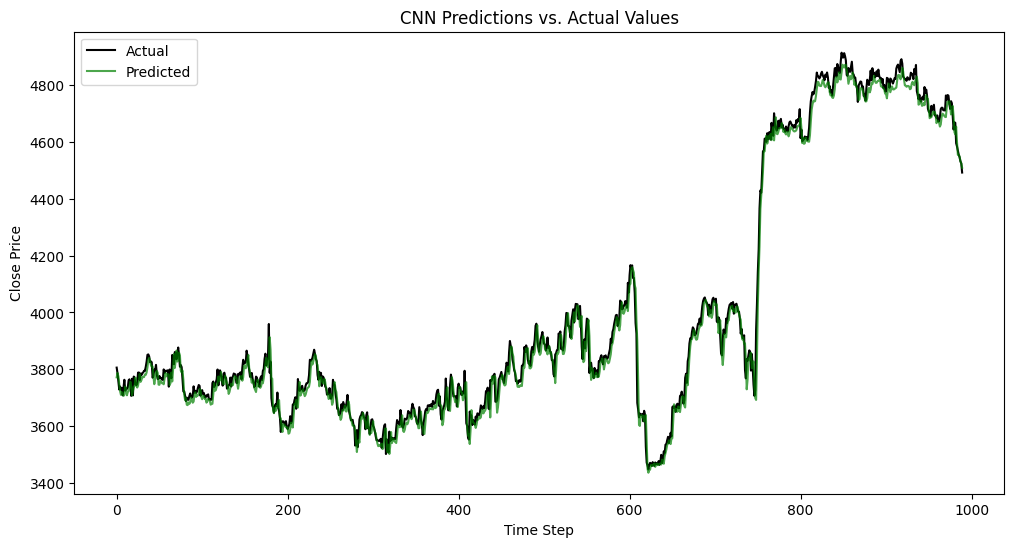

In [ ]:
predictions = model.predict(X)

predictions = scaler.inverse_transform(predictions)
y_original = scaler.inverse_transform(y.reshape(-1, 1))

loss = model.evaluate(X, y)

mae = mean_absolute_error(y_original, predictions)

r2 = r2_score(y_original, predictions)

print(f"Test Loss: {loss}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

plt.figure(figsize=(12, 6))
plt.plot(y_original, label='Actual', color='black')
plt.plot(predictions, label='Predicted', color='green', alpha=0.7)
plt.legend()
plt.title('CNN Predictions vs. Actual Values')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.show()

In [99]:
dataset = pd.read_csv(pwd + '/merged_data.csv', index_col=0)
dataset.head()

,Open,Close,Change,majority_sentiment,average_sentiment
date,,,,,
2025-02-28,3913.54,3915.439,0.048601,2,0.890644
2025-02-27,3908.73,3913.537,0.122904,2,0.954200
2025-02-26,3910.01,3908.733,-0.032736,0,0.812788
2025-02-25,3920.37,3910.013,-0.264057,2,0.835742
2025-02-24,3883.52,3920.365,0.948727,2,0.809047


## CNN (with sentiment)

In [100]:
df = pd.read_csv(pwd +'\merged_data.csv')
df.head()

,date,Open,Close,Change,majority_sentiment,average_sentiment
0,2025-02-28,3913.54,3915.439,0.048601,2,0.890644
1,2025-02-27,3908.73,3913.537,0.122904,2,0.954200
2,2025-02-26,3910.01,3908.733,-0.032736,0,0.812788
3,2025-02-25,3920.37,3910.013,-0.264057,2,0.835742
4,2025-02-24,3883.52,3920.365,0.948727,2,0.809047


In [ ]:

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

feature_columns = df.columns[df.columns != 'Close']
target_column = 'Close'

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

df[feature_columns] = scaler_X.fit_transform(df[feature_columns])
df[target_column] = scaler_y.fit_transform(df[[target_column]])

def create_sequences(data_X, data_y, seq_length):
    xs, ys = [], []
    for i in range(len(data_X) - seq_length):
        xs.append(data_X[i:i+seq_length])
        ys.append(data_y[i+seq_length])
    return np.array(xs), np.array(ys)

seq_length = 10 
X, y = create_sequences(df[feature_columns].values, df[target_column].values, seq_length)


X = X.reshape(X.shape[0], X.shape[1], X.shape[2]))

model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(seq_length, X.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

model.fit(X, y, epochs=50, batch_size=32, verbose=1) 

Epoch 1/50
31/31 [==============================] - 1s 1ms/step - loss: 0.0476
Epoch 2/50
31/31 [==============================] - 0s 1ms/step - loss: 0.0073
Epoch 3/50
31/31 [==============================] - 0s 1ms/step - loss: 0.0047
Epoch 4/50
31/31 [==============================] - 0s 1ms/step - loss: 0.0038
Epoch 5/50
31/31 [==============================] - 0s 1ms/step - loss: 0.0032
Epoch 6/50
31/31 [==============================] - 0s 1ms/step - loss: 0.0028
Epoch 7/50
31/31 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 8/50
31/31 [==============================] - 0s 1ms/step - loss: 0.0021
Epoch 9/50
31/31 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 10/50
31/31 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 11/50
31/31 [==============================] - 0s 1ms/step - loss: 0.0015
Epoch 12/50
31/31 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 13/50
31/31 [==============================

31/31 [==============================] - 0s 1ms/step - loss: 3.4315e-04
Test Loss: 0.0003431527002248913
Mean Absolute Error (MAE): 21.338293489057783
R-squared (R2): 0.9961924779859842


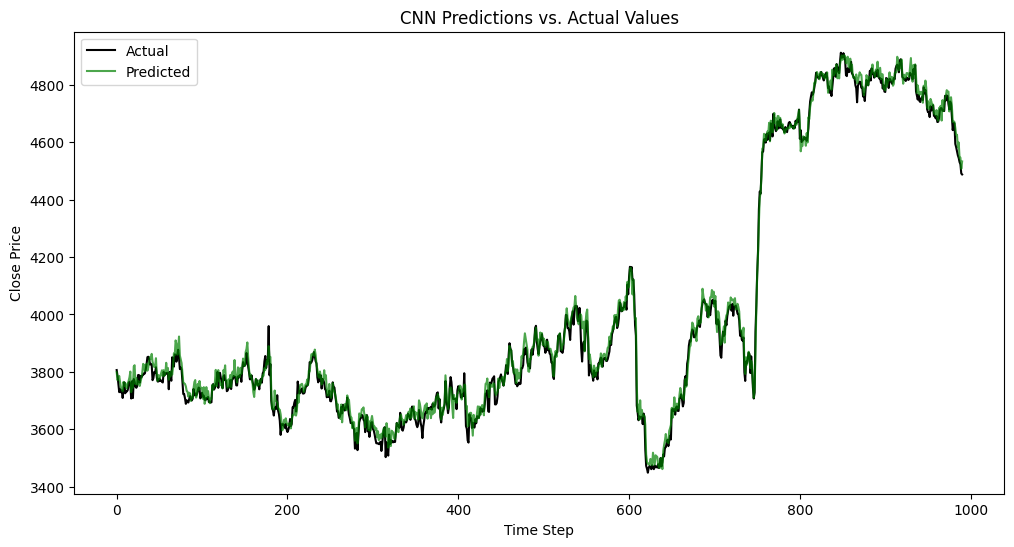

In [ ]:
predictions = model.predict(X)

predictions = scaler_y.inverse_transform(predictions)
y_original = scaler_y.inverse_transform(y.reshape(-1, 1))

loss = model.evaluate(X, y)

mae = mean_absolute_error(y_original, predictions)
r2 = r2_score(y_original, predictions)

print(f"Test Loss: {loss}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

plt.figure(figsize=(12, 6))
plt.plot(y_original, label='Actual', color='black')
plt.plot(predictions, label='Predicted', color='green', alpha=0.7)
plt.legend()
plt.title('CNN Predictions vs. Actual Values')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.show()

## LSTM-CNN (with sentiment)

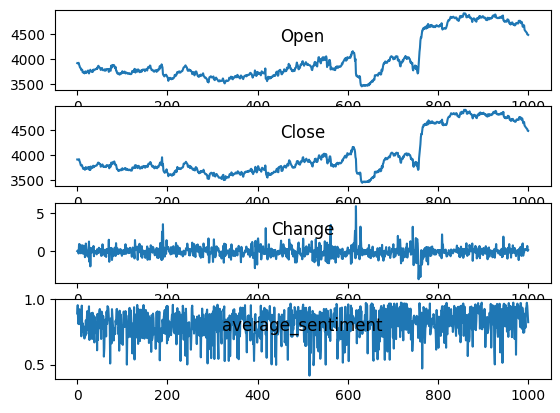

In [ ]:
values = dataset.values

# specify columns to plot
groups = [0, 1, 2, 4]
i = 1

# plot each column
plt.figure()

for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='center')
    i += 1
plt.show()

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:

dataset = pd.read_csv(pwd + '/merged_data.csv', header=0, index_col=0)
values = dataset.values

values = values.astype('float32')


scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


reframed = series_to_supervised(scaled, 1, 1)
print(reframed.columns)

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)'],
      dtype='object')


In [ ]:
reframed.drop(reframed.columns[[5,7,8,9]], axis=1, inplace=True)  # drop all except var2(t) (Close price)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var2(t)
1   0.317778   0.319074   0.384768        1.0   0.850623  0.317775
2   0.314492   0.317775   0.392624        1.0   0.964518  0.314494
3   0.315367   0.314494   0.376168        0.0   0.711102  0.315368
4   0.322442   0.315368   0.351712        1.0   0.752235  0.322438
5   0.297275   0.322438   0.479934        1.0   0.704397  0.297275


In [ ]:
values = reframed.values
n_train = int(len(values) * 0.8)
train = values[:n_train, :]
test = values[n_train:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(800, 1, 5) (800,) (200, 1, 5) (200,)


In [ ]:
n_samples = train_X.shape[0]
n_features = train_X.shape[2]

print(n_samples)
print(n_features)

800
5


In [ ]:
model = Sequential()

model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(1, n_features)))

model.add(MaxPooling1D(pool_size=1))

model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

model.summary()

history = model.fit(train_X, train_y, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(test_X, test_y), 
                    verbose=2, 
                    shuffle=False)

# Predictions
yhat = model.predict(test_X)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 1, 64)             384       
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 1, 64)             0         
 ng1D)                                                           
                                                                 
 lstm_24 (LSTM)              (None, 1, 50)             23000     
                                                                 
 lstm_25 (LSTM)              (None, 50)                20200     
                                                                 
 dense_30 (Dense)            (None, 1)                 51        
                                                                 
Total params: 43635 (170.45 KB)
Trainable params: 43635 (170.45 KB)
Non-trainable params: 0 (0.00 Byte)
_______________

7/7 [==============================] - 0s 2ms/step - loss: 4.3660e-04
Test Loss: 0.0004366027133073658
Mean Absolute Error: 0.01857767254114151
R-squared Score: 0.8770139217376709


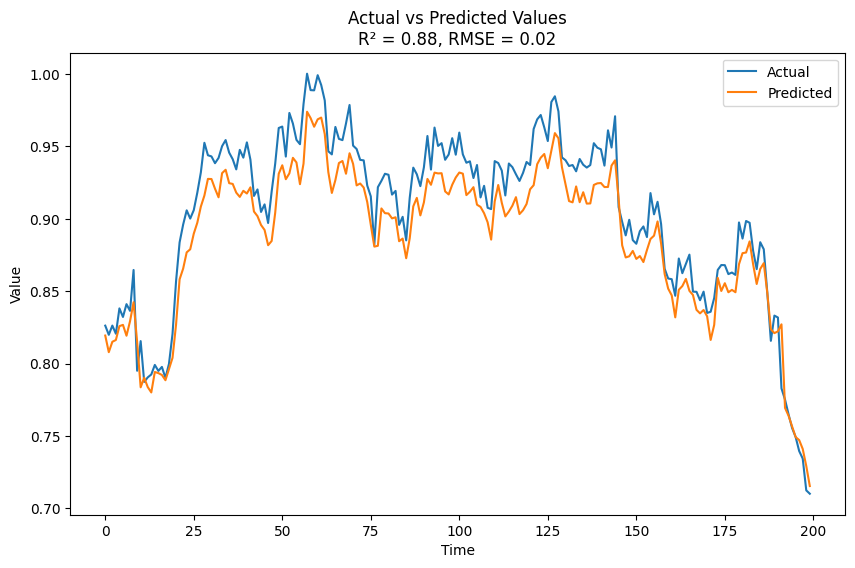

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(test_y, yhat)
mse = mean_squared_error(test_y, yhat)
rmse = np.sqrt(mse)
r2 = r2_score(test_y, yhat)
loss = model.evaluate(test_X, test_y)

print(f'Test Loss: {loss}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared Score: {r2}')

plt.figure(figsize=(10, 6))
plt.plot(test_y, label='Actual')
plt.plot(yhat, label='Predicted')
plt.title(f'Actual vs Predicted Values\nR² = {r2:.2f}, RMSE = {rmse:.2f}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

## LSTM-CNN (without sentiment)

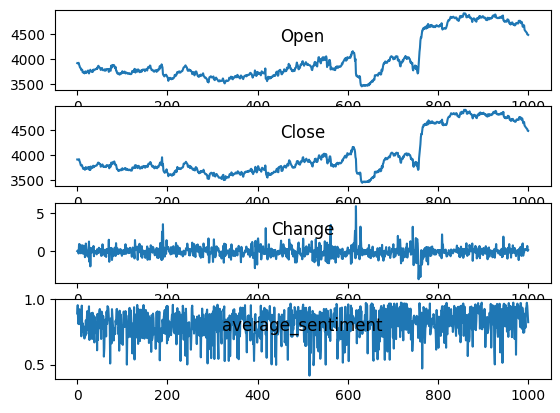

In [103]:
values = dataset.values

# specify columns to plot
groups = [0, 1, 2, 4]
i = 1

# plot each column
plt.figure()

for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='center')
    i += 1
plt.show()

In [ ]:

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()

	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

	agg = pd.concat(cols, axis=1)
	agg.columns = names

	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
dataset = pd.read_csv(pwd + '/merged_data.csv', header=0, index_col=0)
data = dataset[['Change', 'Close', 'Open']]
values = data.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)
print(reframed.columns)

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var1(t)', 'var2(t)', 'var3(t)'], dtype='object')


In [ ]:
reframed.drop(reframed.columns[[3, 5]], axis=1, inplace=True) 
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var2(t)
1   0.384768   0.319074   0.317778  0.317775
2   0.392624   0.317775   0.314492  0.314494
3   0.376168   0.314494   0.315367  0.315368
4   0.351712   0.315368   0.322442  0.322438
5   0.479934   0.322438   0.297275  0.297275


In [202]:
values = reframed.values
n_train = int(len(values) * 0.8)
train = values[:n_train, :]
test = values[n_train:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(800, 1, 3) (800,) (200, 1, 3) (200,)


In [203]:
n_samples = train_X.shape[0]
n_features = train_X.shape[2]

print(n_samples)
print(n_features)

800
3


In [ ]:
model = Sequential()

model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(1, n_features)))

model.add(MaxPooling1D(pool_size=1))

model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

model.summary()

history = model.fit(train_X, train_y, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(test_X, test_y), 
                    verbose=2, 
                    shuffle=False)

yhat = model.predict(test_X)

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_21 (Conv1D)          (None, 1, 64)             256       
                                                                 
 max_pooling1d_18 (MaxPooli  (None, 1, 64)             0         
 ng1D)                                                           
                                                                 
 lstm_36 (LSTM)              (None, 1, 50)             23000     
                                                                 
 lstm_37 (LSTM)              (None, 50)                20200     
                                                                 
 dense_40 (Dense)            (None, 1)                 51        
                                                                 
Total params: 43507 (169.95 KB)
Trainable params: 43507 (169.95 KB)
Non-trainable params: 0 (0.00 Byte)
_______________

7/7 [==============================] - 0s 2ms/step - loss: 6.7529e-05
Test Loss: 6.752867921022698e-05
Mean Absolute Error: 0.005748416297137737
R-squared Score: 0.9809779524803162


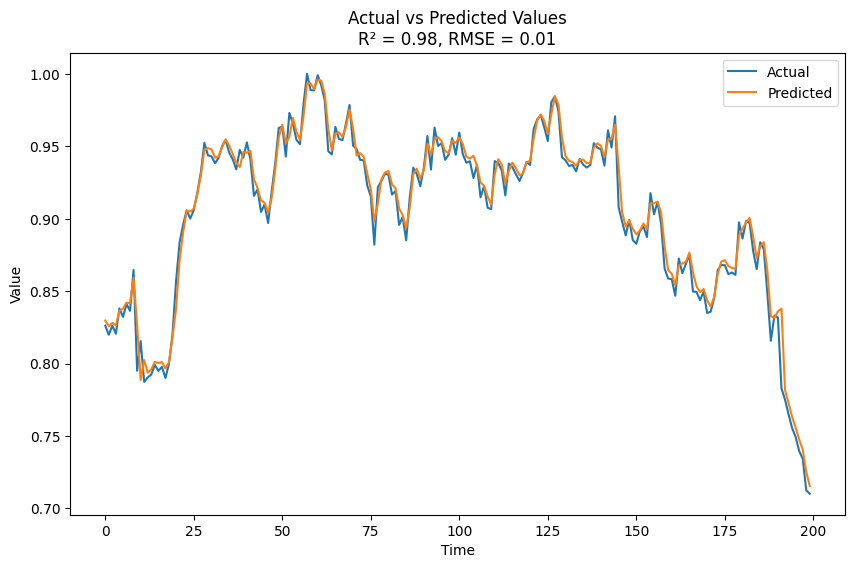

In [205]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(test_y, yhat)
mse = mean_squared_error(test_y, yhat)
rmse = np.sqrt(mse)
r2 = r2_score(test_y, yhat)
loss = model.evaluate(test_X, test_y)

print(f'Test Loss: {loss}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared Score: {r2}')

plt.figure(figsize=(10, 6))
plt.plot(test_y, label='Actual')
plt.plot(yhat, label='Predicted')
plt.title(f'Actual vs Predicted Values\nR² = {r2:.2f}, RMSE = {rmse:.2f}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

## rolling cross validation


---------------------------------------------------------------------------------------------------

## LSTM (without sentiment variables)

In [ ]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length, -1] 
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(mi_data[['Open', 'Close', 'Change']])

seq_length = 10
X, y = create_sequences(scaled_data, seq_length)

n_splits = 5
train_size = int(len(X) * 0.8)  
test_size = int(len(X) * 0.2)   

fold_results = []

for fold in range(n_splits):
    print(f'\nFold {fold + 1}')
 
    train_start = fold * test_size
    train_end = train_start + train_size
    test_start = train_end
    test_end = test_start + test_size
    
    if test_end > len(X):
        break
        

    X_train = X[train_start:train_end]
    X_val = X[test_start:test_end]
    y_train = y[train_start:train_end]
    y_val = y[test_start:test_end]
    
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_val, y_val),
        verbose=1
    )
    
    y_pred = model.predict(X_val)
    
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    fold_results.append({
        'fold': fold + 1,
        'mae': mae,
        'r2': r2
    })
    
    print(f'Fold {fold + 1} Results:')
    print(f'MAE: {mae:.4f}')
    print(f'R2 Score: {r2:.4f}')

avg_results = pd.DataFrame(fold_results).mean()
print('\nAverage Results:')
print(f'Average MAE: {avg_results["mae"]:.4f}')
print(f'Average R2 Score: {avg_results["r2"]:.4f}')


Fold 1
Epoch 1/50
22/22 [==============================] - 5s 44ms/step - loss: 0.0439 - val_loss: 0.0061
Epoch 2/50
22/22 [==============================] - 0s 8ms/step - loss: 0.0067 - val_loss: 0.0033
Epoch 3/50
22/22 [==============================] - 0s 8ms/step - loss: 0.0067 - val_loss: 0.0040
Epoch 4/50
22/22 [==============================] - 0s 9ms/step - loss: 0.0064 - val_loss: 0.0033
Epoch 5/50
22/22 [==============================] - 0s 8ms/step - loss: 0.0064 - val_loss: 0.0031
Epoch 6/50
22/22 [==============================] - 0s 8ms/step - loss: 0.0063 - val_loss: 0.0033
Epoch 7/50
22/22 [==============================] - 0s 8ms/step - loss: 0.0063 - val_loss: 0.0032
Epoch 8/50
22/22 [==============================] - 0s 9ms/step - loss: 0.0066 - val_loss: 0.0032
Epoch 9/50
22/22 [==============================] - 0s 9ms/step - loss: 0.0063 - val_loss: 0.0032
Epoch 10/50
22/22 [==============================] - 0s 9ms/step - loss: 0.0062 - val_loss: 0.0031
Epoch 11/5

## LSTM (with sentiment variables)

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(mi_data[['Open', 'Close', 'Change', 'majority_sentiment', 'average_sentiment']])

seq_length = 10
X, y = create_sequences(scaled_data, seq_length)

n_splits = 5
train_size = int(len(X) * 0.8)  
test_size = int(len(X) * 0.2) 

fold_results = []

for fold in range(n_splits):
    print(f'\nFold {fold + 1}')
    
    train_start = fold * test_size
    train_end = train_start + train_size
    test_start = train_end
    test_end = test_start + test_size
    
    if test_end > len(X):
        break
        
    X_train = X[train_start:train_end]
    X_val = X[test_start:test_end]
    y_train = y[train_start:train_end]
    y_val = y[test_start:test_end]
    
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_val, y_val),
        verbose=1
    )
    
    y_pred = model.predict(X_val)
    
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    fold_results.append({
        'fold': fold + 1,
        'mae': mae,
        'r2': r2
    })
    
    print(f'Fold {fold + 1} Results:')
    print(f'MAE: {mae:.4f}')
    print(f'R2 Score: {r2:.4f}')

avg_results = pd.DataFrame(fold_results).mean()
print('\nAverage Results:')
print(f'Average MAE: {avg_results["mae"]:.4f}')
print(f'Average R2 Score: {avg_results["r2"]:.4f}')


Fold 1
Epoch 1/50
25/25 [==============================] - 4s 41ms/step - loss: 0.1006 - val_loss: 0.0334
Epoch 2/50
25/25 [==============================] - 0s 9ms/step - loss: 0.0401 - val_loss: 0.0313
Epoch 3/50
25/25 [==============================] - 0s 9ms/step - loss: 0.0380 - val_loss: 0.0327
Epoch 4/50
25/25 [==============================] - 0s 9ms/step - loss: 0.0374 - val_loss: 0.0316
Epoch 5/50
25/25 [==============================] - 0s 9ms/step - loss: 0.0373 - val_loss: 0.0312
Epoch 6/50
25/25 [==============================] - 0s 9ms/step - loss: 0.0371 - val_loss: 0.0309
Epoch 7/50
25/25 [==============================] - 0s 9ms/step - loss: 0.0372 - val_loss: 0.0313
Epoch 8/50
25/25 [==============================] - 0s 9ms/step - loss: 0.0377 - val_loss: 0.0308
Epoch 9/50
25/25 [==============================] - 0s 9ms/step - loss: 0.0382 - val_loss: 0.0308
Epoch 10/50
25/25 [==============================] - 0s 8ms/step - loss: 0.0377 - val_loss: 0.0308
Epoch 11/5

## CNN-LSTM (without sentiment variables)

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(mi_data[['Open', 'Close', 'Change']])

seq_length = 10
X, y = create_sequences(scaled_data, seq_length)

tscv = TimeSeriesSplit(n_splits=5)

fold_results = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    print(f'\nFold {fold + 1}')
    
    train_size = int(len(train_idx) * 0.8)
    train_start = 0
    train_end = train_size
    test_start = train_size
    test_end = len(train_idx)
    
    X_train = X[train_start:train_end]
    X_val = X[test_start:test_end]
    y_train = y[train_start:train_end]
    y_val = y[test_start:test_end]
    
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_val, y_val),
        verbose=1
    )
    
    y_pred = model.predict(X_val)
    
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    fold_results.append({
        'fold': fold + 1,
        'mae': mae,
        'r2': r2
    })
    
    print(f'Fold {fold + 1} Results:')
    print(f'MAE: {mae:.4f}')
    print(f'R2 Score: {r2:.4f}')

avg_results = pd.DataFrame(fold_results).mean()
print('\nAverage Results:')
print(f'Average MAE: {avg_results["mae"]:.4f}')
print(f'Average R2 Score: {avg_results["r2"]:.4f}')


Fold 1
Epoch 1/50
5/5 [==============================] - 4s 202ms/step - loss: 0.0682 - val_loss: 0.0057
Epoch 2/50
5/5 [==============================] - 0s 16ms/step - loss: 0.0161 - val_loss: 0.0111
Epoch 3/50
5/5 [==============================] - 0s 14ms/step - loss: 0.0043 - val_loss: 0.0055
Epoch 4/50
5/5 [==============================] - 0s 16ms/step - loss: 0.0094 - val_loss: 0.0029
Epoch 5/50
5/5 [==============================] - 0s 16ms/step - loss: 0.0035 - val_loss: 0.0056
Epoch 6/50
5/5 [==============================] - 0s 19ms/step - loss: 0.0058 - val_loss: 0.0060
Epoch 7/50
5/5 [==============================] - 0s 17ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 8/50
5/5 [==============================] - 0s 16ms/step - loss: 0.0043 - val_loss: 0.0023
Epoch 9/50
5/5 [==============================] - 0s 15ms/step - loss: 0.0038 - val_loss: 0.0027
Epoch 10/50
5/5 [==============================] - 0s 16ms/step - loss: 0.0031 - val_loss: 0.0036
Epoch 11/50
5/5 [===

## CNN-LSTM (with sentiment variables)

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(mi_data[['Open', 'Close', 'Change', 'majority_sentiment', 'average_sentiment']])

seq_length = 10
X, y = create_sequences(scaled_data, seq_length)

tscv = TimeSeriesSplit(n_splits=5)

fold_results = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    print(f'\nFold {fold + 1}')
    
    train_size = int(len(train_idx) * 0.8)
    train_start = 0
    train_end = train_size
    test_start = train_size
    test_end = len(train_idx)
    
    X_train = X[train_start:train_end]
    X_val = X[test_start:test_end]
    y_train = y[train_start:train_end]
    y_val = y[test_start:test_end]
    
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_val, y_val),
        verbose=1
    )
    
    y_pred = model.predict(X_val)
    
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    fold_results.append({
        'fold': fold + 1,
        'mae': mae,
        'r2': r2
    })
    
    print(f'Fold {fold + 1} Results:')
    print(f'MAE: {mae:.4f}')
    print(f'R2 Score: {r2:.4f}')

avg_results = pd.DataFrame(fold_results).mean()
print('\nAverage Results:')
print(f'Average MAE: {avg_results["mae"]:.4f}')
print(f'Average R2 Score: {avg_results["r2"]:.4f}')


Fold 1
Epoch 1/50
5/5 [==============================] - 4s 194ms/step - loss: 0.4707 - val_loss: 0.1140
Epoch 2/50
5/5 [==============================] - 0s 15ms/step - loss: 0.0742 - val_loss: 0.0858
Epoch 3/50
5/5 [==============================] - 0s 15ms/step - loss: 0.0929 - val_loss: 0.0264
Epoch 4/50
5/5 [==============================] - 0s 15ms/step - loss: 0.0401 - val_loss: 0.0340
Epoch 5/50
5/5 [==============================] - 0s 15ms/step - loss: 0.0502 - val_loss: 0.0218
Epoch 6/50
5/5 [==============================] - 0s 15ms/step - loss: 0.0366 - val_loss: 0.0317
Epoch 7/50
5/5 [==============================] - 0s 17ms/step - loss: 0.0457 - val_loss: 0.0240
Epoch 8/50
5/5 [==============================] - 0s 15ms/step - loss: 0.0377 - val_loss: 0.0239
Epoch 9/50
5/5 [==============================] - 0s 15ms/step - loss: 0.0426 - val_loss: 0.0229
Epoch 10/50
5/5 [==============================] - 0s 15ms/step - loss: 0.0402 - val_loss: 0.0237
Epoch 11/50
5/5 [===

# CNN



In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, -1]) 
    return np.array(X), np.array(y)

mi_data = pd.read_csv(pwd + '\merged_data.csv')
mbw_data = pd.read_csv(fr'C:\Users\ivane\Desktop\Dissertation\data\merged_data.csv')

mi_data['date'] = pd.to_datetime(mi_data['date'])
mbw_data['Date'] = pd.to_datetime(mbw_data['Date'])

mi_data = mi_data.sort_values('date')
mbw_data = mbw_data.sort_values('Date')

mi_data = mi_data.reset_index(drop=True)
mbw_data = mbw_data.reset_index(drop=True)

print("Malta Independent Data Shape:", mi_data.shape)
print("Malta Business Weekly Data Shape:", mbw_data.shape)

def train_cnn(data, features, title):
    print(f"\n### {title} ###")
    
    scaled_data = scaler.fit_transform(data[features])
    
    seq_length = 10
    X, y = create_sequences(scaled_data, seq_length)
    
    test_size = 0.2
    window_size = int(len(X) * (1 - test_size))
    step_size = int(window_size * 0.2) 
    
    fold_results = []
    fold = 1
    
    for start_idx in range(0, len(X) - window_size, step_size):
        print(f'\nFold {fold}')
        
        train_idx = list(range(start_idx, start_idx + window_size))
        val_idx = list(range(start_idx + window_size, min(start_idx + window_size + int(window_size * test_size/(1-test_size)), len(X))))
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        model = Sequential([
            Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
            MaxPooling1D(pool_size=2),
            Conv1D(filters=32, kernel_size=3, activation='relu'),
            MaxPooling1D(pool_size=2),
            Flatten(),
            Dense(50, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')
        
        history = model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=32,
            validation_data=(X_val, y_val),
            verbose=1
        )
        
        y_pred = model.predict(X_val)
        
        mae = mean_absolute_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        
        fold_results.append({'fold': fold, 'mae': mae, 'r2': r2})
        
        print(f'Fold {fold} Results:')
        print(f'MAE: {mae:.4f}')
        print(f'R2 Score: {r2:.4f}')
        
        fold += 1
    
    avg_results = pd.DataFrame(fold_results).mean()
    print('\nAverage Results:')
    print(f'Average MAE: {avg_results["mae"]:.4f}')
    print(f'Average R2 Score: {avg_results["r2"]:.4f}')

train_cnn(mi_data, ['Open', 'Close', 'Change'], "CNN (MI - Without Sentiment)")
train_cnn(mi_data, ['Open', 'Close', 'Change', 'majority_sentiment', 'average_sentiment'], "CNN (MI - With Sentiment)")

train_cnn(mbw_data, ['Open', 'Close', 'Change'], "CNN (MBW - Without Sentiment)")
train_cnn(mbw_data, ['Open', 'Close', 'Change', 'sentiment', 'sentiment_score'], "CNN (MBW - With Sentiment)")


Malta Independent Data Shape: (1001, 6)
Malta Business Weekly Data Shape: (430, 6)

### CNN (MI - Without Sentiment) ###

Fold 1
Epoch 1/50
25/25 [==============================] - 1s 8ms/step - loss: 0.0447 - val_loss: 0.0097
Epoch 2/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0071 - val_loss: 0.0045
Epoch 3/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0061 - val_loss: 0.0045
Epoch 4/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0059 - val_loss: 0.0045
Epoch 5/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0060 - val_loss: 0.0045
Epoch 6/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0059 - val_loss: 0.0045
Epoch 7/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0058 - val_loss: 0.0044
Epoch 8/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0058 - val_loss: 0.0044
Epoch 9/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0059 - val_lo

# Results

# Results of models (using 80:20 split)
## Malta Independant
### LSTM (Without Sentiment Variable)
Test Loss (MSE): 0.0005052234046161175  
Mean Absolute Error (MAE): 31.609900023181  
R-squared (R2): 0.8499226893849482

### LSTM (With Sentiment Variable)
Test Loss (MSE): 0.00017181661678478122  
Mean Absolute Error (MAE): 14.83542593518725  
R-squared (R2): 0.9489616321833064

### CNN (Without Sentiment Variable)
Test Loss: 0.0006718079675920308  
Mean Absolute Error (MAE): 27.978281632733594  
R-squared (R2): 0.9925441399012059

### CNN (With Sentiment Variable)
Test Loss: 0.0003431527002248913  
Mean Absolute Error (MAE): 21.338293489057783  
R-squared (R2): 0.9961924779859842

### LSTM-CNN (Without Sentiment Variable)
Test Loss: 6.752867921022698e-05  
Mean Absolute Error: 0.005748416297137737  
R-squared Score: 0.9809779524803162

### LSTM-CNN (With Sentiment Variable)
Test Loss: 0.0004366027133073658  
Mean Absolute Error: 0.01857767254114151  
R-squared Score: 0.8770139217376709

## Malta Business Weekly
### LSTM (Without Sentiment Variable)
Test Loss (MSE): 0.004844771232455969  
Mean Absolute Error (MAE): 22.84890668012559  
R-squared (R2): 0.8364785544463473

### LSTM (With Sentiment Variable)
Test Loss (MSE): 0.003929056227207184  
Mean Absolute Error (MAE): 19.498368677307738  
R-squared (R2): 0.8673858845904483

### CNN (Without Sentiment Variable)
Test Loss: 0.0045250775292515755  
Mean Absolute Error (MAE): 22.37676582544003  
R-squared (R2): 0.8921590963553585

### CNN (With Sentiment Variable)
Test Loss: 0.0026346512604504824  
Mean Absolute Error (MAE): 17.783706468564006  
R-squared (R2): 0.9375191722991122

### LSTM-CNN (Without Sentiment Variable)
Test Loss: 0.0024828610476106405  
Mean Absolute Error: 0.027093494310975075  
R-squared Score: 0.9190030097961426

### LSTM-CNN (With Sentiment Variable)
Test Loss: 0.00026312240515835583  
Mean Absolute Error: 0.012569311074912548  
R-squared Score: 0.9258814454078674

# Results of models (using time series rolling cross validation)
## Malta Independent
### LSTM (Without Sentiment)
Average Results:  
Average MAE: 0.0645  
Average R2 Score: -0.3523  

### LSTM (With Sentiment)
Average Results:  
Average MAE: 0.1590  
Average R2 Score: -0.1212

### CNN (Without Sentiment)
Average Results:  
Average MAE: 0.0647  
Average R2 Score: -0.3268  

### CNN (With Sentiment)
Average Results:  
Average MAE: 0.1686  
Average R2 Score: -0.2462  

### CNN-LSTM (Without Sentiment)
Average Results:  
Average MAE: 0.0647  
Average R2 Score: -0.2970  

### CNN-LSTM (WitH Sentiment)
Average Results:  
Average MAE: 0.1616  
Average R2 Score: -0.1008  

## Malta Business Weekly
### LSTM (Without Sentiment)
Average Results:  
Average MAE: 0.0786  
Average R2 Score: -0.0311  

### LSTM (With Sentiment)
Average Results:  
Average MAE: 0.1918  
Average R2 Score: -0.0367  

### CNN (Without Sentiment)
Average Results:  
Average MAE: 0.0876  
Average R2 Score: -0.1880  

### CNN (With Sentiment)
Average Results:  
Average MAE: 0.1913  
Average R2 Score: -0.0979  

### CNN-LSTM (Without Sentiment)
Average Results:  
Average MAE: 0.0805  
Average R2 Score: -0.0561  

### CNN-LSTM (WitH Sentiment)
Average Results:  
Average MAE: 0.1973  
Average R2 Score: -0.0955  

Here’s the updated analysis incorporating the new results with the same structure as before:

---

Based on your model results from the two news sources (Malta Independent and Malta Business Weekly), I'll analyze the impact of different sentiment sources and the value added by including sentiment variables.

## Q1: Impact of Different Sources for Sentiment

When comparing the Malta Independent vs. Malta Business Weekly as sentiment sources:

### **LSTM Models**
- **With Sentiment**: Malta Independent performs better in an 80:20 split (R² 0.949 vs. 0.867), but worse in time-series CV (-0.121 vs. -0.037).  
- **Without Sentiment**: Malta Independent performs better in an 80:20 split (R² 0.850 vs. 0.836) but worse in time-series CV (-0.352 vs. -0.031).

### **CNN Models**
- **With Sentiment**: Malta Independent performs better in an 80:20 split (R² 0.996 vs. 0.938), but worse in time-series CV (-0.246 vs. -0.098).  
- **Without Sentiment**: Malta Independent performs better in an 80:20 split (R² 0.993 vs. 0.892), but worse in time-series CV (-0.327 vs. -0.188).

### **LSTM-CNN Models**
- **With Sentiment**: Malta Business Weekly performs better in an 80:20 split (R² 0.926 vs. 0.877) and in time-series CV (-0.096 vs. -0.101).  
- **Without Sentiment**: Malta Independent performs better in an 80:20 split (R² 0.981 vs. 0.919), but Malta Business Weekly performs better in time-series CV (-0.056 vs. -0.297).

### **Key Findings:**
1. **In the 80:20 split**, Malta Independent generally provides stronger sentiment signals, especially for simpler models like LSTM and CNN.  
2. **In time-series cross-validation**, Malta Business Weekly consistently performs better, suggesting its sentiment scores might be more stable over time.  
3. **LSTM-CNN models** favor Malta Business Weekly sentiment data, potentially due to its structure capturing temporal patterns better.  

---

## Q2: Added Value of Sentiment Variable

### **Malta Independent**
#### **80:20 Split**
- **LSTM**: Adding sentiment improves R² from 0.850 to 0.949 (+11.7%).  
- **CNN**: Adding sentiment improves R² from 0.993 to 0.996 (+0.3%).  
- **LSTM-CNN**: Adding sentiment **decreases** R² from 0.981 to 0.877 (-10.6%).  

#### **Time-Series Cross Validation**
- **LSTM**: Adding sentiment improves R² from -0.352 to -0.121 (+23.1%).  
- **CNN**: Adding sentiment **decreases** R² from -0.327 to -0.246 (-8.1%).  
- **LSTM-CNN**: Adding sentiment **improves** R² from -0.297 to -0.101 (+19.6%).  

### **Malta Business Weekly**
#### **80:20 Split**
- **LSTM**: Adding sentiment improves R² from 0.836 to 0.867 (+3.7%).  
- **CNN**: Adding sentiment improves R² from 0.892 to 0.938 (+5.1%).  
- **LSTM-CNN**: Adding sentiment improves R² from 0.919 to 0.926 (+0.8%).  

#### **Time-Series Cross Validation**
- **LSTM**: Adding sentiment **decreases** R² from -0.031 to -0.037 (-0.6%).  
- **CNN**: Adding sentiment **improves** R² from -0.188 to -0.098 (+9.0%).  
- **LSTM-CNN**: Adding sentiment **decreases** R² from -0.056 to -0.096 (-4.0%).  

### **Key Findings:**
1. **In an 80:20 split**, sentiment generally improves performance, especially for LSTM models using Malta Independent sentiment.  
2. **In time-series cross-validation**, sentiment's impact is less clear—sometimes improving results, sometimes reducing stability.  
3. **For Malta Independent**, sentiment helps LSTM models but degrades CNN and hybrid LSTM-CNN performance.  
4. **For Malta Business Weekly**, sentiment has a more balanced impact across models, but the improvements are smaller.  

### **Conclusion:**
Sentiment data does add predictive value, particularly when using a static 80:20 split. However, its effectiveness diminishes when using time-series cross-validation, suggesting possible **overfitting in holdout testing** or that sentiment is **not consistently predictive over time**. Malta Independent sentiment is stronger in short-term predictions, while Malta Business Weekly sentiment appears more stable for time-series validation.

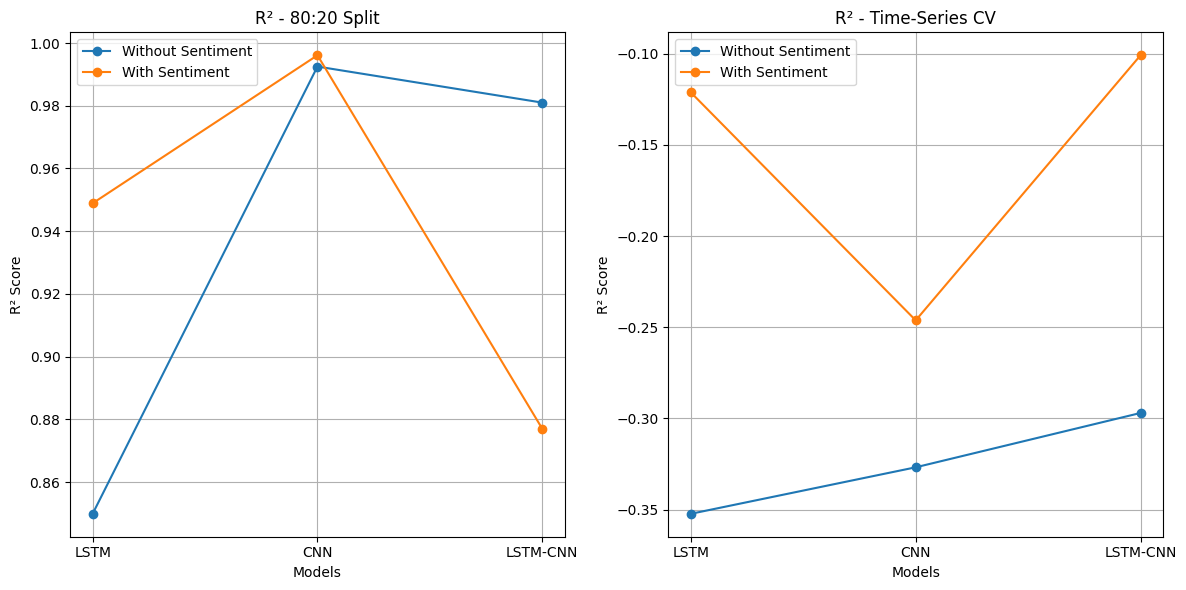

In [6]:
# Define the data for visualization
# Define R² data for visualization
r2_data = {
    '80:20 Split': {
        'Without Sentiment': [0.8499, 0.9925, 0.9810],  # LSTM, CNN, LSTM-CNN
        'With Sentiment': [0.9489, 0.9961, 0.8770]      # LSTM, CNN, LSTM-CNN
    },
    'Time-Series CV': {
        'Without Sentiment': [-0.3523, -0.3268, -0.2970],  # LSTM, CNN, LSTM-CNN
        'With Sentiment': [-0.1212, -0.2462, -0.1008]      # LSTM, CNN, LSTM-CNN
    }
}

# Plot R²
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for i, split in enumerate(splits):
    ax = axes[i]
    for config in configurations:
        ax.plot(models, r2_data[split][config], marker='o', label=config)
    ax.set_title(f'R² - {split}')
    ax.set_ylabel('R² Score')
    ax.set_xlabel('Models')
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()


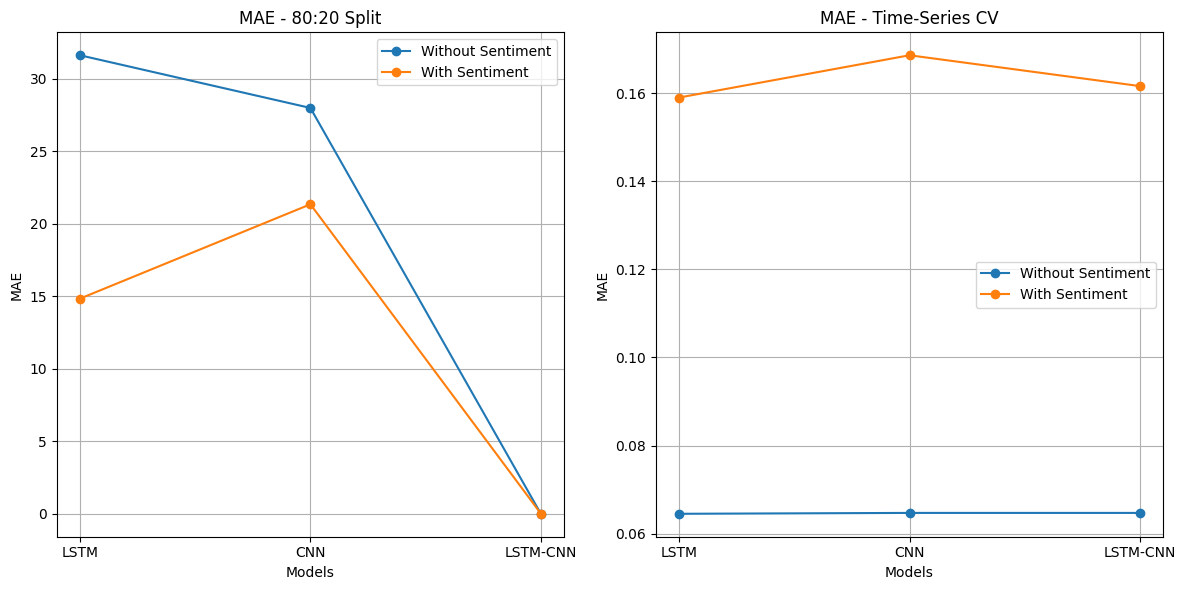

In [8]:
# Define MAE data for visualization
mae_data = {
    '80:20 Split': {
        'Without Sentiment': [31.6099, 27.9783, 0.0057],  # LSTM, CNN, LSTM-CNN
        'With Sentiment': [14.8354, 21.3383, 0.0186]      # LSTM, CNN, LSTM-CNN
    },
    'Time-Series CV': {
        'Without Sentiment': [0.0645, 0.0647, 0.0647],    # LSTM, CNN, LSTM-CNN
        'With Sentiment': [0.1590, 0.1686, 0.1616]        # LSTM, CNN, LSTM-CNN
    }
}

# Plot MAE
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for i, split in enumerate(splits):
    ax = axes[i]
    for config in configurations:
        ax.plot(models, mae_data[split][config], marker='o', label=config)
    ax.set_title(f'MAE - {split}')
    ax.set_ylabel('MAE')
    ax.set_xlabel('Models')
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()